In [1]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Prep_Figure_5")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict

# 5a - Score Summary?

In [87]:
drug_pairs = pd.read_csv("../../Data/Krogan_Drug_Candidates.txt", sep="\t")

In [88]:
# Parse Ligand Docking Results
pair2scores = dict()
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("../../Data/Ligands/{0}*".format(drug))[0]
    
    try:
        uni_f = glob.glob("../../Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    # Load all docking sub-batches
    outs = glob.glob("../../Data/Docked_Ligands/sub_batches/{0}_{1}_*.pdb".format(uni, drug))
    
    scores = sorted(my.flatten([[float(x.split()[-1]) for x in my.call("grep minimizedAffinity " + out)] for out in outs]))
    
    pair2scores[(drug, uni)] = scores

('WDB002', 'Q9BV73')
('Midostaurin', 'P27448')
('Midostaurin', 'Q7KZI7')


{u'bodies': [<matplotlib.collections.PolyCollection at 0x7fb79572bcd0>,
 u'cbars': <matplotlib.collections.LineCollection at 0x7fb795eecc10>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x7fb79572bb50>,
 u'cmins': <matplotlib.collections.LineCollection at 0x7fb795eec890>}

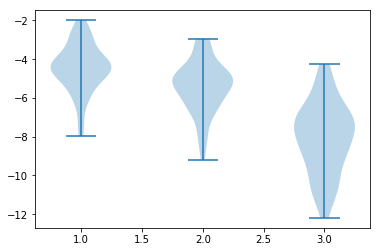

In [90]:
best_scores = []
worst_scores = []
all_scores = []
for k in pair2scores:
    scores = pair2scores[k]
    if(len(scores) == 0):
        print k
        continue
    #plt.plot([x / float(len(scores)) for x in range(len(scores))], scores[::-1])
    best_scores.append(scores[0])
    worst_scores.append(scores[-1])
    all_scores.append(np.mean(scores))
plt.violinplot([worst_scores, all_scores, best_scores])

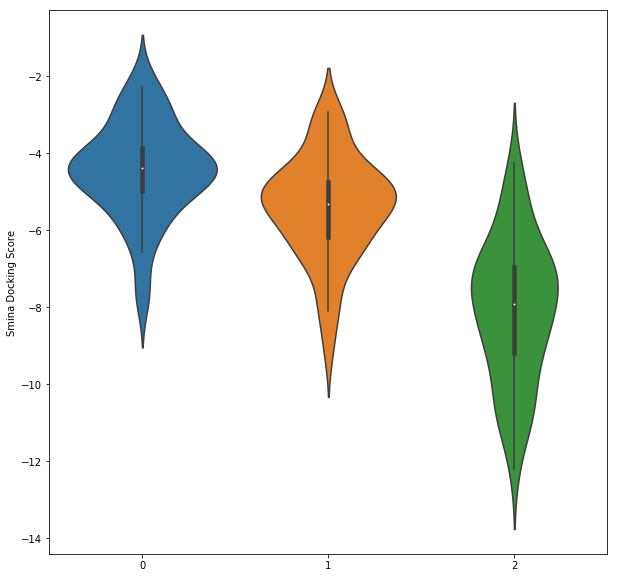

In [97]:
plt.figure(figsize=(10, 10))
sns.violinplot(data=[worst_scores, all_scores, best_scores])
plt.ylabel("Smina Docking Score")
plt.savefig("Fig_5a_Docking_Scores.svg")

# 5b - Overall Enrichment

# 5c - Individual Enrichment

# 5d-e - Docked Structures

In [25]:
# Calculate ddG using a random mut (just to get the PDB files with the energy contributions for regular dG calculation)
p1 = "COVID19orf6"
p2 = "P52948"
pdb = "../../Data/Docked_Structures/{0}_{1}_top_dock.pdb".format(p1, p2)
rank = "1"
muts = "1_A"
trials = 50
interface_cutoff = 8
out_base = "ddG_Scored_Structures/"
my.call("mkdir -p {0}".format(out_base))
os.system("python ../../Mutant_ddG_Calc.py {0} {1} {2} {3} {4} {5} {6} {7}".format(p1, p2, pdb, rank, muts, trials, interface_cutoff, out_base))

0

In [26]:
#!python ../../Mutant_ddG_Calc.py COVID19orf6 P52948 ../../Data/Docked_Structures/COVID19orf6_P52948_top_dock.pdb 1 1_A 1 8 ddG_Scored_Structures/

In [29]:
def fetch_scores_from_pdb(pdb, pdb_df=None, relabel=True):
    if(relabel and (pdb_df is None)):
        pdb_df = my.pdb2df(pdb)
    
    lines = my.easyReadLines(pdb)
    keep = []
    flag = True
    for l in lines:
        if(flag and not "#BEGIN" in l):
            continue
        else:
            flag = False
            keep.append(l)
    scores1 = pd.DataFrame([x.split() for x in keep[3:-2]], columns=keep[1].split())
    
    if(relabel):
        scores1["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
        scores1["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
        scores1["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
        
        scores1 = scores1[["Chain", "Res", "Resi"] + list(scores1)[1:-3]]
    
    return scores1
# FUNCTION END

def calc_ddG_per_residue(base, pdb_df=None, calc="ddG"):
    wt_comp = sorted(glob.glob("{0}_*WT_Complex.pdb".format(base)))
    mut_comp = sorted(glob.glob("{0}_*Mut_Complex.pdb".format(base)))
    wt_sep = sorted(glob.glob("{0}_*WT_Separate.pdb".format(base)))
    mut_sep = sorted(glob.glob("{0}_*Mut_Separate.pdb".format(base)))
    
    pdb_df = my.pdb2df(wt_comp[0])
    
    trials = []
    for wt_c, wt_sep, mut_c, mut_sep in zip(wt_comp, wt_sep, mut_comp, mut_sep):
        a = fetch_scores_from_pdb(wt_c, relabel=False)
        b = fetch_scores_from_pdb(wt_sep, relabel=False)
        
        c = fetch_scores_from_pdb(mut_c, relabel=False)
        d = fetch_scores_from_pdb(mut_sep, relabel=False)
        
        if(calc == "ddG"):
            ddg = (c[list(c)[1:]].astype(float) - d[list(d)[1:]].astype(float)) - (a[list(a)[1:]].astype(float) - b[list(b)[1:]].astype(float))
        elif(calc == "dG"):
            ddg = (a[list(a)[1:]].astype(float) - b[list(b)[1:]].astype(float))
        else:
            print "Unknown Calculation Type"
            1/0
        
        trials.append(ddg)
    ddg = sum(trials) / float(len(trials))
    
    ddg["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
    ddg["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
    ddg["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
    
    ddg = ddg[["Chain", "Res", "Resi"] + list(ddg)[:-3]]
    
    return ddg
# FUNCTION END

In [34]:
dG = calc_ddG_per_residue("ddG_Scored_Structures/COVID19orf6_P52948_1*", calc="dG")

In [36]:
# These are the "wrong" residues (i.e. not the contact site that we actually care about)
dG[dG["total"] != 0]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,0.026920,-0.006322,-0.018660,-0.52555,-1.32672,-1.850060
1,A,MET,1,0.002878,-0.002766,-0.001319,0.00000,0.00000,-0.001207
2,A,PHE,2,0.000020,0.000027,-0.000005,0.00000,0.00000,0.000042
3,A,HIS,3,0.000006,0.000000,0.000000,0.00000,0.00000,0.000006
20,A,ARG,20,0.000000,0.000000,0.000000,-0.26277,-0.66336,-0.926140
22,A,PHE,22,0.000063,0.000000,0.000000,0.00000,0.00000,0.000063
25,A,SER,25,-0.000035,0.000000,0.000104,0.00000,0.00000,0.000069
26,A,ILE,26,-0.002621,0.000000,-0.002163,0.00000,0.00000,-0.004785
27,A,TRP,27,0.013438,-0.003188,-0.009321,0.00000,0.00000,0.000930
28,A,ASN,28,0.007835,-0.000128,-0.010682,0.00000,0.00000,-0.002975


In [38]:
ddg_scan = pd.read_csv("../../Data/ddG_Single_Mutants/Summaries/COVID19orf6_P52948_1_Mean.txt", sep="\t").set_index(["Chain", "Ref", "Pos"])
ddg_scan = ddg_scan[[x for x in ddg_scan if "avg" in x]]

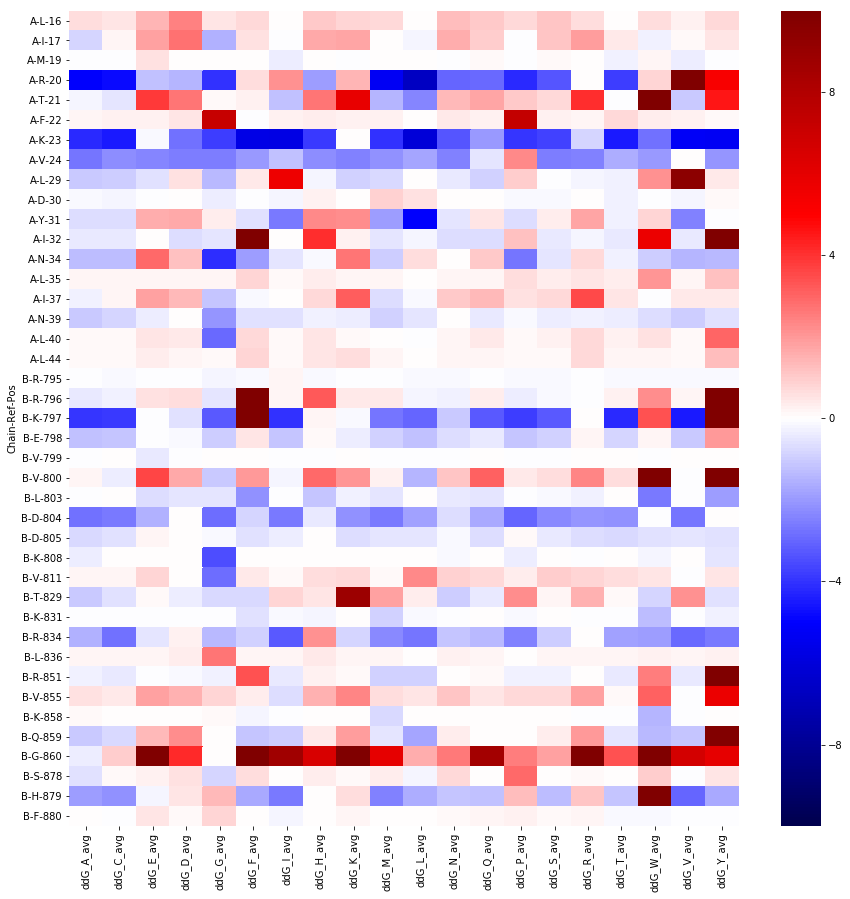

In [42]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(ddg_scan, annot=False, cmap="seismic", center=0, vmin=-10, vmax=10)

In [43]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd

In [45]:
def polarpairs(sel1, sel2, cutoff=4.0, angle=63.0, name='', state=1, quiet=1):
    '''
ARGUMENTS

    sel1, sel2 = string: atom selections

    cutoff = float: distance cutoff

    angle = float: h-bond angle cutoff in degrees. If angle="default", take
    "h_bond_max_angle" setting. If angle=0, do not detect h-bonding.

    name = string: If given, also create a distance object for visual representation

SEE ALSO

    pymolCmd.find_pairs, pymolCmd.distance
    '''
    cutoff = float(cutoff)
    quiet = int(quiet)
    state = int(state)
    if angle == 'default':
        angle = pymolCmd.get('h_bond_max_angle', pymolCmd.get_object_list(sel1)[0])
    angle = float(angle)
    mode = 1 if angle > 0 else 0
    x = pymolCmd.find_pairs('(%s) and donors' % sel1, '(%s) and acceptors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle) + \
        pymolCmd.find_pairs('(%s) and acceptors' % sel1, '(%s) and donors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle)
    x = sorted(set(x))
    if not quiet:
        print('Settings: cutoff=%.1fangstrom angle=%.1fdegree' % (cutoff, angle))
        print('Found %d polar contacts' % (len(x)))
    if len(name) > 0:
        for p in x:
            pymolCmd.distance(name, '(%s`%s)' % p[0], '(%s`%s)' % p[1])
    return x
# FUNCTION END

pymolCmd.extend('polarpairs', polarpairs)

<function __main__.polarpairs>

In [83]:
tmp = my.call("grep P52948 ../../Data/Interface_Summary.txt | grep Docking")[0].split("\t")
iresV = [int(x) for x in tmp[-4].split(",")]
iresH = [int(x) for x in tmp[-1].split(",")]
print iresV
print iresH
iresHD = [int(x) for x in my.call("grep P52948 ../../Data/Drug_Docking_Ires_Summary.txt")[0].split("\t")[-1].split(",")]
print iresHD

[16, 17, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 34, 35, 37, 39, 40, 44]
[795, 796, 797, 798, 799, 800, 803, 804, 805, 808, 811, 829, 831, 834, 836, 851, 855, 858, 859, 860, 878, 879, 880]
[797, 828, 829, 830, 831, 842, 846, 847, 851, 855]


In [80]:
tmp

['16,17,19,20,21,22,23,24,29,30,31,32,34,35,37,39,40,44']

In [82]:
!python ../../irescalc_ligand.py ../../Data/Undocked_Structures/P52948_1KO6_A.pdb ../../Data/Docked_Ligands/ranked_poses/P52948_Verdinexor_1.pdb -uSASA 0

797,826,828,829,830,831,837,842,846,847,848,851,852,855,873


In [85]:
tmp = my.call("irescalc.py ../../Data/Docked_Structures/COVID19orf6_P52948_top_dock.pdb -c1 A -c2 B -uSASA 0")
iresV = [int(x) for x in tmp[0].split(",")]
iresH = [int(x) for x in tmp[1].split(",")]
print iresV
print iresH
iresHD = [int(x) for x in my.call("python ../../irescalc_ligand.py ../../Data/Undocked_Structures/P52948_1KO6_A.pdb ../../Data/Docked_Ligands/ranked_poses/P52948_Verdinexor_1.pdb -uSASA 0")[0].split(",")]
print iresHD

[16, 17, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 34, 35, 37, 39, 40, 44]
[795, 796, 797, 798, 799, 800, 801, 803, 804, 805, 808, 811, 826, 827, 829, 831, 834, 836, 848, 851, 852, 855, 858, 859, 860, 861, 873, 875, 877, 878, 879, 880]
[797, 826, 828, 829, 830, 831, 837, 842, 846, 847, 848, 851, 852, 855, 873]


In [86]:
pymolCmd.reinitialize()

# Load PPI
A = "COVID19orf6"
B = "NUP98_PPI"
pymolCmd.load("../../Data/Docked_Structures/COVID19orf6_P52948_top_dock.pdb", A)
pymolCmd.extract(B, A + " and chain B")

# Load PDI
C = "NUP98_PDI"
D = "Verdinexor"
pymolCmd.load("../../Data/Undocked_Structures/P52948_1KO6_A.pdb", C)
pymolCmd.load("../../Data/Docked_Ligands/P52948_Verdinexor.pdb", D, state=1)
pymolCmd.align(C, B)
pymolCmd.matrix_copy(C, D)
#pymolCmd.extract(C, D + " and resn UNL")

pymolCmd.extract("Junk", "element h and not " + D)
pymolCmd.delete("Junk")

# Initial Display Settings
pymolCmd.show("cartoon", "not " + D)
pymolCmd.show("sticks", D)
pymolCmd.hide("lines", "all")


# Color Chains
cmapA = matplotlib.cm.Blues
cmapB = matplotlib.cm.Greens

pymolCmd.save("orf6_NUP98_Drug_Figure.pse")

vires = "{0} and (resi {1})".format(A, " or resi ".join([str(x) for x in iresV]))
hires_PPI = "{0} and (resi {1})".format(B, " or resi ".join([str(x) for x in iresH]))
hires_PDI = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresHD]))
sA = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresH]))
sB = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresHD]))

pymolCmd.select("orf6_Ires", vires)
pymolCmd.select("NUP98_PPI_ires", hires_PPI)
pymolCmd.select("NUP98_PDI_ires", hires_PDI)
pymolCmd.select("sA", sA)
pymolCmd.select("sB", sB)
pymolCmd.select("sC", sA + " and " + sB)

pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), A)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), B + " or " + C)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "orf6_Ires")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "NUP98_PPI_ires")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "NUP98_PDI_ires")


# Display lines for Ires
pymolCmd.show("sticks", "(orf6_Ires or NUP98_PPI_ires or NUP98_PDI_ires) and (sidechain or name CA)")

# Create super surface
for name in [A, B, C]:
    pymolCmd.copy_to(name + "_Surface", name)
    pymolCmd.hide("everything", name + "_Surface")
    pymolCmd.show("surface", name + "_Surface")
#pymolCmd.set("transparency", 0.6)

# Color by element
pymolCmd.color("atomic", "({0} or {1} or {2} or {3}) and not element C".format(A, B, C, D))

# Hide Hydrogens
pymolCmd.hide("everything", "element h")

# Flag Polar Contacts
pairs1 = polarpairs(A, B, name="PPI_Polar_Pairs")
pairs2 = polarpairs(C, D, name="PDI_Polar_Pairs")
if(len(pairs1)):
    pymolCmd.hide("labels", "PPI_Polar_Pairs")
if(len(pairs2)):
    pymolCmd.hide("labels", "PDI_Polar_Pairs")
print len(pairs1)
print len(pairs2)

pymolCmd.save("orf6_NUP98_Drug_Figure.pse")

#non_ires_sele = "chain A and not (resi {0})".format(" or resi ".join([str(x) for x in iresA])) + " or " + "chain B and not (resi {0})".format(" or resi ".join([str(x) for x in iresB]))
#pymolCmd.select("Non-Ires", non_ires_sele) 

9
8


In [75]:
vires

'COVID19orf6 and (resi 16 or resi 17 or resi 19 or resi 20 or resi 21 or resi 22 or resi 23 or resi 24 or resi 29 or resi 30 or resi 31 or resi 32 or resi 34 or resi 35 or resi 37 or resi 39 or resi 40 or resi 44)'

In [106]:
pop_vars = pd.read_csv("../../Data/Pop_Vars.txt", sep="\t")

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
ddg_fs =  glob.glob("../../Data/ddG_Single_Mutants/Summaries/*Mean.txt")

In [144]:
tmp = []
for f in ddg_fs:
    uni = f.split("_")[-3]
    ddgs = pd.read_csv(f, sep="\t")
    ddgs = ddgs[ddgs["Chain"] == "B"].set_index("Pos")
    pvs = pop_vars[pop_vars["UniProt"] == uni]
    s1 = set(pvs["AA_Pos"].unique())
    s2 = set(ddgs.index)
    for pos, ref, alt in pvs[["AA_Pos", "AA_Ref", "AA_Alt"]].values:
        if(not pos in s2):
            continue
        #if(not pos == 207):
        #    continue
        #print pos, ref, alt
        try:
            if(ddgs.ix[pos,:]["Ref"] == ref):
                #print "A"
                tmp.append([uni, pos, ref, alt, ddgs.ix[pos,:]["ddG_{0}_avg".format(alt)]])
        except KeyError:
            raise
    #break
    #if(len(tmp) != 0):
    #    break

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


(-10, 10)

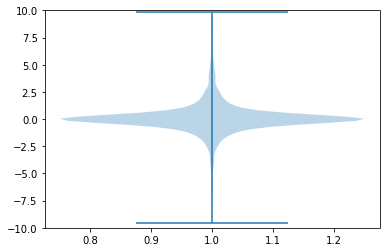

In [162]:
summary = pd.DataFrame(tmp, columns=["Uni", "Pos", "Ref", "Alt", "ddG"])
plt.violinplot(summary[summary["ddG"].map(lambda x: -10 <= x <= 10)]["ddG"].to_list())
plt.ylim(-10, 10)

In [175]:
a = 37
b = 295
c = 1660
d = 22008

In [166]:
(a*d) / float(b*c)

1.66284664080049

               Case  Non-Case
Exposed        37.0     295.0
Non-Exposed  1660.0   22008.0


(1.66284664080049,
 2.3489729811302356,
 1.1771352727484479,
 0.0019555004906737228)

In [198]:
a = 45
b = 86
c = 32
d = 100
pd.DataFrame([[a, b], [c, d]], columns=["Case", "Non-Case"], index=["Exposed", "Non-Exposed"])

,Case,Non-Case
Exposed,45,86
Non-Exposed,32,100


In [201]:
exposure_mask = np.zeros(sum([a, b, c, d]))
case_mask = np.zeros(sum([a, b, c, d]))
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1
print
print "Odds Ratio: {0}     Upper_CI: {1}     Lower_CI: {2}     p-value: {3}".format(*my.odds_ratio(exposure_mask, case_mask, verbose=True, two_sided=False))


             Case  Non-Case
Exposed      45.0      86.0
Non-Exposed  32.0     100.0
Odds Ratio: 1.6351744186     Upper_CI: 2.56641963602     Lower_CI: 1.04183873195     p-value: 0.0727465107441


In [197]:
from scipy.stats import chi2_contingency
print "Test Statistic: {0}     p-value: {1}".format(*chi2_contingency(np.array([[a, b], [c, d]])))

Test Statistic: 8.77974837662     p-value: 0.00304593213142


In [172]:
(a*d) / float(b*c)

2.0

In [ ]:
sele A and chain A and (resi 3  or resi 4  or resi 21 or resi 22 or resi 32 or resi 39 or resi 40 or resi 46 or resi 52 or resi 60 or resi 61 or resi 63 or resi 65 or resi 66 or resi 67 or resi 68 or resi 71 or resi 72 or resi 73)



In [1]:
0

0

In [3]:
import os
import sys
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

In [4]:
ires_df = pd.read_csv("../../Data/Interface_Summary.txt", sep="\t")
pairs = ires_df[ires_df["Source"] == "Docking"][["P1", "P2"]].apply(lambda x: tuple(x), axis=1).to_list()

In [ ]:
        wt_packed_complex.dump_pdb(out_filename.replace(".pdb", "WT_Complex.pdb"))
        wt_packed_separate.dump_pdb(out_filename.replace(".pdb", "WT_Separate.pdb"))
        mut_packed_complex.dump_pdb(out_filename.replace(".pdb", "Mut_Complex.pdb"))
        mut_packed_separate.dump_pdb(out_filename.replace(".pdb", "Mut_Separate.pdb"))


In [5]:
out_base = "../../Data/ddG_Mutated_Structures/"

In [6]:
pbar = tqdm_notebook(total=len(pairs)*50*40)
out = open("Move_Log.txt", "w")
for p1, p2 in pairs:
    os.system("mkdir ../../Data/ddG_Mutated_Structures/All_Structures/{0}_{1}".format(p1, p2))
    for rank in range(50):
        for trial in range(10, 50):
            out.write(str(os.system("mv {0}{1}_{2}_{3}_SARS_Muts_{4}WT_Complex.pdb {0}/All_Structures/{5}_{6}/{1}_{2}_{3}_SARS_Muts_{4}WT_Complex.pdb".format(out_base, p1, p2, rank, trial+1, p1, p2))) + "\n")
            out.write(str(os.system("mv {0}{1}_{2}_{3}_SARS_Muts_{4}WT_Separate.pdb {0}/All_Structures/{5}_{6}/{1}_{2}_{3}_SARS_Muts_{4}WT_Separate.pdb".format(out_base, p1, p2, rank, trial+1, p1, p2))) + "\n")
            out.write(str(os.system("mv {0}{1}_{2}_{3}_SARS_Muts_{4}Mut_Complex.pdb {0}/All_Structures/{5}_{6}/{1}_{2}_{3}_SARS_Muts_{4}Mut_Complex.pdb".format(out_base, p1, p2, rank, trial+1, p1, p2))) + "\n")
            out.write(str(os.system("mv {0}{1}_{2}_{3}_SARS_Muts_{4}Mut_Separate.pdb {0}/All_Structures/{5}_{6}/{1}_{2}_{3}_SARS_Muts_{4}Mut_Separate.pdb".format(out_base, p1, p2, rank, trial+1, p1, p2))) + "\n")
            pbar.update(1)
            #break
        #break
    #break

In [ ]:
"{0}{1}_{2}_{3}_SARS_Muts_{4}.pdb".format(out_base, p1, p2, rank, trial+1)

In [ ]:
0

In [11]:
"mv {0}{1}_{2}_{3}_SARS_Muts_{4}.pdb" "{0}/All_Structures/{5}_{6}/{1}_{2}_{3}_SARS_Muts_{4}.pdb".format(out_base, p1, p2, rank, trial+1, p1, p2)

'mv ../../Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G4_0_SARS_Muts_1.pdb../../Data/ddG_Mutated_Structures//All_Structures/COVID19Spike_Q7Z5G4/COVID19Spike_Q7Z5G4_0_SARS_Muts_1.pdb'

In [2]:
0

0